# Book Recommendation System

## Introduction

In this project, we will build a Book Recommendation System using Natural Language Processing (NLP) and dimensionality reduction techniques. We will use TF-IDF Vectorization and Singular Value Decomposition (SVD) to recommend books based on their features.

## Dataset

The dataset books_new.csv includes information about books with the following columns:

• 'Title'

• 'Author'

• 'Genre'

• 'SubGenre'

• 'Height'

• 'Publisher'

### Import Libraries

In [7]:
import time
import logging
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

### Logger Configuration

In [9]:
# Configure the logger
logging.basicConfig(
    filename='app.log',  # Log file name
    level=logging.INFO,  # Logging level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(levelname)s - %(message)s'  # Log message format
)
# Start measuring time
start_time = time.time()

## EDA (Exploratory Data Analysis)

In this section, we perform exploratory data analysis to understand the dataset better and uncover insights that can guide our feature engineering and model building process.

### Load the Data

In [13]:
# Load the dataset
try:
    books = pd.read_csv('books_new.csv')
    logging.info('Dataset loaded successfully.')
except Exception as e:
    logging.error(f'Error loading dataset: {e}')

### Inspect the Dataset

In [15]:
# Inspect the first few rows of the dataset
print("First few rows of the dataset:")
books.head()

First few rows of the dataset:


,Title,Author,Genre,SubGenre,Height,Publisher
0,Fundamentals of Wavelets,"Goswami, Jaideva",tech,signal_processing,228,Wiley
1,Data Smart,"Foreman, John",tech,data_science,235,Wiley
2,God Created the Integers,"Hawking, Stephen",tech,mathematics,197,Penguin
3,Superfreakonomics,"Dubner, Stephen",science,economics,179,HarperCollins
4,Orientalism,"Said, Edward",nonfiction,history,197,Penguin


In [16]:
# Summary statistics of the dataset
print("\nSummary statistics of the dataset:")
books.describe(include='all')


Summary statistics of the dataset:


,Title,Author,Genre,SubGenre,Height,Publisher
count,211,187,211,211,211.000000,115
unique,210,129,5,22,NaN,33
top,Angels & Demons,"Steinbeck, John",fiction,novel,NaN,Penguin
freq,2,8,77,38,NaN,34
mean,NaN,NaN,NaN,NaN,206.056872,NaN
std,NaN,NaN,NaN,NaN,26.828141,NaN
min,NaN,NaN,NaN,NaN,160.000000,NaN
25%,NaN,NaN,NaN,NaN,180.000000,NaN
50%,NaN,NaN,NaN,NaN,199.000000,NaN
75%,NaN,NaN,NaN,NaN,229.500000,NaN


### Check for Missing Values

In [18]:
# Check for missing values
print("\nMissing values in the dataset:")
missing_values = books.isnull().sum()
print(missing_values)


Missing values in the dataset:
Title         0
Author       24
Genre         0
SubGenre      0
Height        0
Publisher    96
dtype: int64


### Distribution of Book Genres

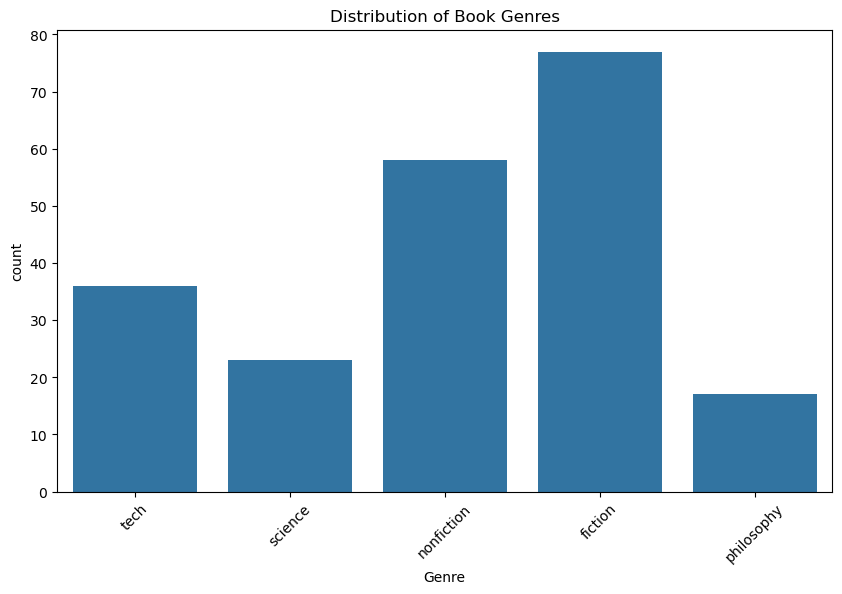

In [20]:
# Distribution of book genres
plt.figure(figsize=(10, 6))
sns.countplot(data=books, x='Genre')
plt.title('Distribution of Book Genres')
plt.xticks(rotation=45)
plt.show()

The distribution of book genres shows how books are spread across different categories. If one genre dominates, the recommendation model might need balancing to avoid genre bias.

### Distribution of Book Authors

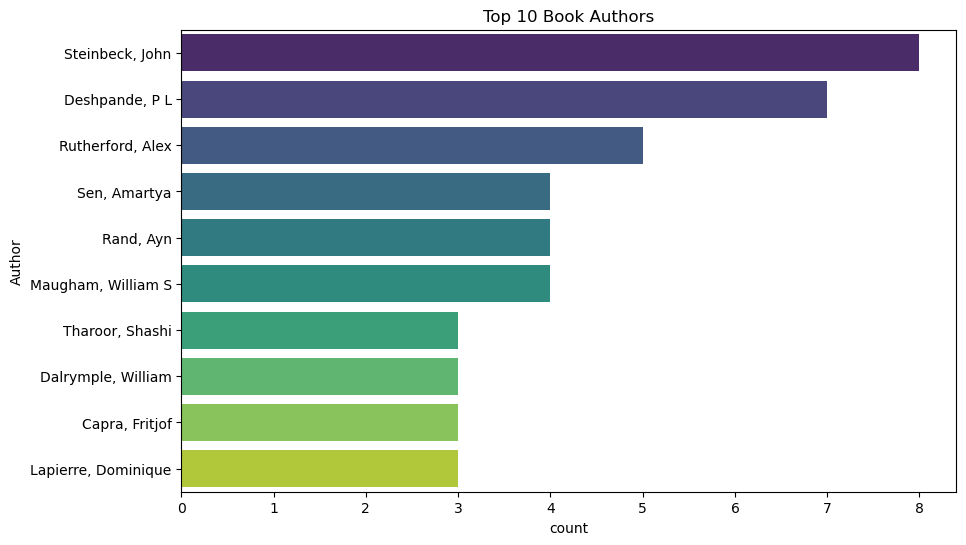

In [23]:
# Distribution of Top 10 book authors
top_authors = books['Author'].value_counts().head(10).index
top_authors_data = books[books['Author'].isin(top_authors)]

plt.figure(figsize=(10, 6))
sns.countplot(data=top_authors_data, y='Author', order=top_authors, palette='viridis')
plt.title('Top 10 Book Authors')
plt.show()

This visualization highlights the most prolific authors in the dataset. It gives insight into author dominance and potential bias toward popular authors when recommending books.

### Text Data Analysis: Word Cloud for Book Titles

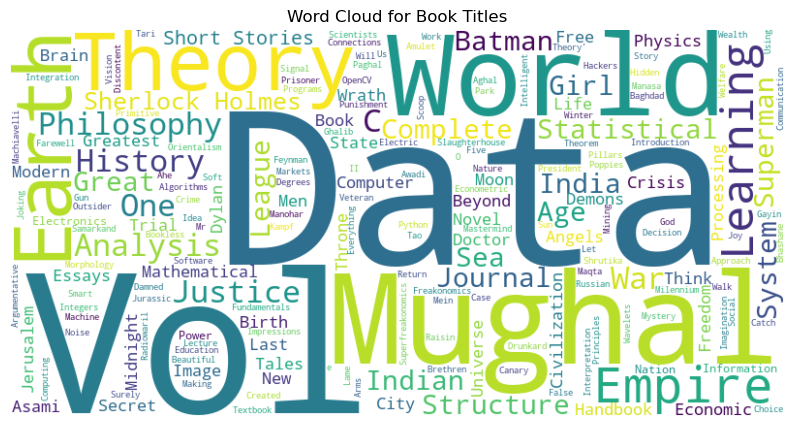

In [26]:
# Example of text data analysis: Word Cloud for Book Titles
text = ' '.join(books['Title'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Book Titles')
plt.show()

The Word Cloud reveals common words in book titles, helping identify prevalent themes or topics. This can guide the model when making recommendations based on title content.

### Distribution of Book Heights

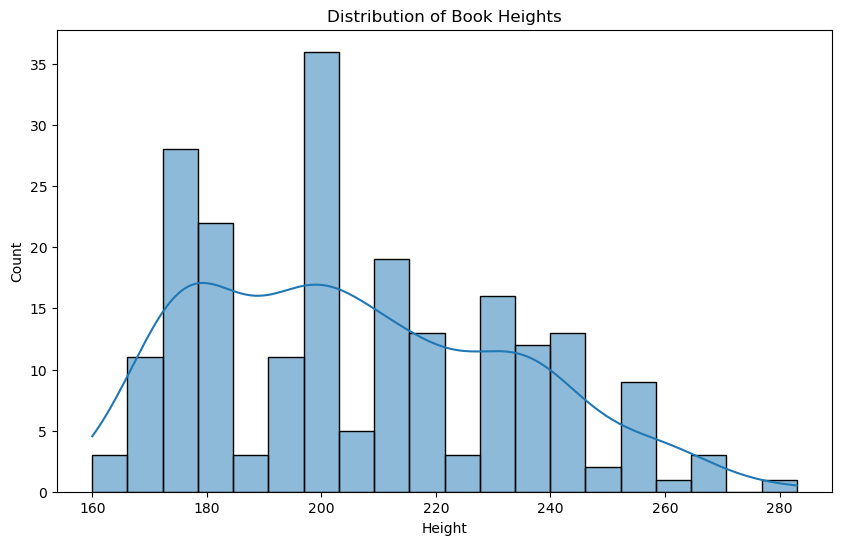

In [29]:
# Distribution of book heights
plt.figure(figsize=(10, 6))
sns.histplot(books['Height'], bins=20, kde=True)
plt.title('Distribution of Book Heights')
plt.show()

The distribution of book heights provides a sense of physical dimensions in the dataset. This feature could be useful for recommending books based on size preferences or for physical storage management.

### Categorical Columns Analysis

In [32]:
# Value counts for categorical columns
print("\nValue counts for 'Genre':")
print(books['Genre'].value_counts())


Value counts for 'Genre':
Genre
fiction       77
nonfiction    58
tech          36
science       23
philosophy    17
Name: count, dtype: int64


In [33]:
print("\nValue counts for 'SubGenre':")
print(books['SubGenre'].value_counts())


Value counts for 'SubGenre':
SubGenre
novel                38
history              34
classic              26
data_science         14
comic                13
mathematics          11
economics            11
autobiography        11
computer_science     10
signal_processing     7
misc                  7
physics               7
philosophy            6
objectivism           3
psychology            3
science               2
education             2
legal                 2
trivia                1
poetry                1
anthology             1
politics              1
Name: count, dtype: int64


In [34]:
print("\nValue counts for 'Publisher':")
print(books['Publisher'].value_counts())


Value counts for 'Publisher':
Publisher
Penguin             34
Random House        17
Mauj                 7
HarperCollins        6
O'Reilly             4
Vintage              3
Springer             3
Pearson              3
vikas                3
MIT Press            3
Rupa                 3
Jaico                3
Pan                  2
Routledge            2
Wiley                2
Apress               2
Prentice Hall        2
FreePress            1
Picador              1
HighStakes           1
Simon&Schuster       1
Fontana              1
Pocket               1
TMH                  1
Elsevier             1
BBC                  1
Hyperion             1
Transworld           1
HBA                  1
Bodley Head          1
CRC                  1
Orient Blackswan     1
Dell                 1
Name: count, dtype: int64


These counts show the frequency of different categories. Genre and SubGenre are important for thematic recommendations, while Publisher insights could reflect bias toward certain publishing houses.

### Numerical Columns Analysis

In [37]:
# Basic statistics for 'Height'
height_data = books['Height'].values
mean_height = np.mean(height_data)
median_height = np.median(height_data)
std_height = np.std(height_data)
percentiles_height = np.percentile(height_data, [25, 50, 75])

print(f"Mean Height: {mean_height}")
print(f"Median Height: {median_height}")
print(f"Standard Deviation of Height: {std_height}")
print(f"25th, 50th, and 75th Percentiles of Height: {percentiles_height}")

Mean Height: 206.0568720379147
Median Height: 199.0
Standard Deviation of Height: 26.764491360733754
25th, 50th, and 75th Percentiles of Height: [180.  199.  229.5]


These statistics provide a summary of the 'Height' feature, including the central tendency and spread. This could help identify the most common book sizes in the dataset.

### Check for Duplicate Records

In [40]:
# Check for duplicate records
print("\nNumber of duplicate records in the dataset:")
print(books.duplicated().sum())


Number of duplicate records in the dataset:
0


0 duplicates in the dataset means the data is clean, and no duplicate handling is required. This ensures accurate analysis and model training without redundant entries.

### Boxplot for Height to Detect Outliers

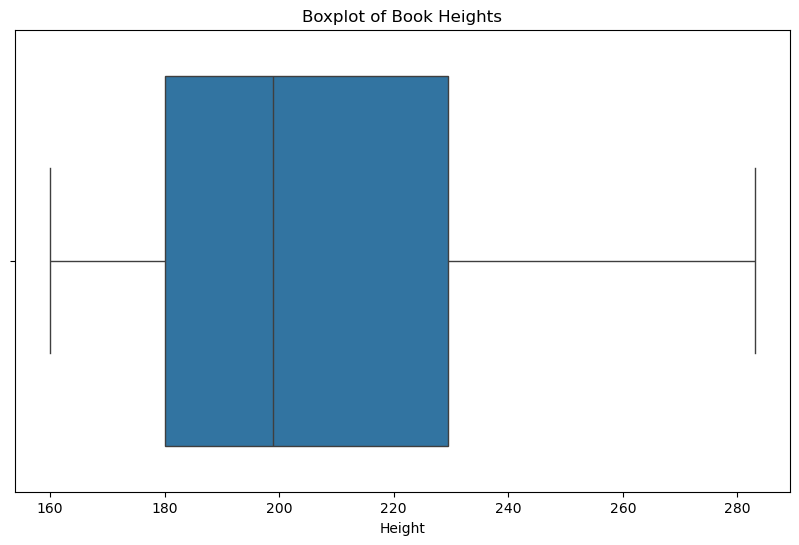

In [43]:
# Boxplot for Height to detect outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=books['Height'])
plt.title('Boxplot of Book Heights')
plt.show()

The boxplot indicates that there are no outliers in the height data, meaning all book heights fall within a reasonable range.

## Data Preprocessing

In this section, we clean and transform the dataset by handling missing values, rearranging book titles, and scaling the numerical features.

### Rearrange Book Titles

In [48]:
# Define function to rearrange book title
def rearrange_title(title):
    if title.endswith(", The"):
        return "The " + title[:-5]
    elif title.endswith(", A"):
        return "A " + title[:-3]
    elif title.startswith("The ") or title.startswith("A "):
        return title
    return title

# Apply the function to the 'Title' column
try:
    books['Title'] = books['Title'].apply(rearrange_title)
    logging.info('Book titles rearranged.')
except Exception as e:
    logging.error(f'Error rearranging book titles: {e}')

### Impute Missing Values

In [50]:
# Impute missing values
try:
    books['Author'].fillna('Unknown Author', inplace=True)
    books['Publisher'].fillna('Unknown Publisher', inplace=True)
    logging.info('Missing values imputed.')
except Exception as e:
    logging.error(f'Error imputing missing values: {e}')

### Remove Commas and Extra Spaces from the 'Author' Column

In [52]:
# Remove commas and extra spaces from the 'Author' column
try:
    books['Author'] = books['Author'].str.replace(',', '').str.strip()
    logging.info('Removed commas and extra spaces from Author column.')
except Exception as e:
    logging.error(f'Error processing Author column: {e}')

### Scale Height

In [54]:
# Scaling Height
try:
    scaler = StandardScaler()
    books['Height'] = scaler.fit_transform(books[['Height']])
    logging.info('Height column scaled.')
except Exception as e:
    logging.error(f'Error scaling Height column: {e}')

## Feature Engineering

In [56]:
# Merge all columns except 'Height' and 'Title'
try:
    books['CombinedFeatures'] = books[['Genre', 'SubGenre', 'Author', 'Publisher']].astype(str).agg(' '.join, axis=1)
    books['CombinedFeatures'] = books['CombinedFeatures'] + ' ' + books['Height'].astype(str)
    logging.info('Combined features created.')
except Exception as e:
    logging.error(f'Error combining features: {e}')

## Model Building

We'll use TF-IDF Vectorization and SVD for dimensionality reduction to compute cosine similarity between books.

### Apply TF-IDF Vectorization

In [60]:
# Apply TF-IDF Vectorization
try:
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(books['CombinedFeatures'])
    logging.info('TF-IDF vectorization applied.')
except Exception as e:
    logging.error(f'Error applying TF-IDF vectorization: {e}')

### Apply SVD for Dimensionality Reduction

In [62]:
# Apply SVD for dimensionality reduction
try:
    svd = TruncatedSVD(n_components=100)
    svd_matrix = svd.fit_transform(tfidf_matrix)
    logging.info('SVD dimensionality reduction applied.')
except Exception as e:
    logging.error(f'Error applying SVD: {e}')

### Compute Cosine Similarity

In [64]:
# Compute cosine similarity
try:
    cosine_sim_svd = cosine_similarity(svd_matrix, svd_matrix)
    logging.info('Cosine similarity computed.')
except Exception as e:
    logging.error(f'Error computing cosine similarity: {e}')

## Recommendation Function

The recommendation function will provide book recommendations based on the similarity scores computed.

### Define Recommendation Functionn Function

In [68]:
# Recommendation function using SVD-based cosine similarity
def recommend_book_svd(book_title, cosine_sim_matrix, books_df):
    """
    Recommend books based on the cosine similarity of the SVD-transformed features.

    Args:
        book_title (str): The title of the book to base recommendations on.
        cosine_sim_matrix (array-like): The cosine similarity matrix of book features.
        books_df (DataFrame): The DataFrame containing book data.

    Returns:
        list: A list of recommended book titles.
    """
    if book_title not in books_df['Title'].values:
        logging.warning(f'Book "{book_title}" not found in the dataset.')
        return "Book not found in the dataset."

    book_index = books_df[books_df['Title'] == book_title].index[0]
    similarity_scores = list(enumerate(cosine_sim_matrix[book_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:11]  # Exclude the first book (itself)
    book_indices = [i[0] for i in similarity_scores]
    
    recommendations = books_df['Title'].iloc[book_indices].tolist()
    logging.info(f'Recommendations for book "{book_title}": {recommendations}')
    return recommendations

### Example Recommendation

In [70]:
# Example recommendation
try:
    recommended_books = recommend_book_svd('Complete Sherlock Holmes, The - Vol I', cosine_sim_svd, books)
    for book in recommended_books:
        print(book)
except Exception as e:
    logging.error(f'Error recommending books: {e}')

Complete Sherlock Holmes, The - Vol II
The Pillars of the Earth
Slaughterhouse Five
The Hunchback of Notre Dame
Catch 22
The Trial
The Brethren
The Amulet of Samarkand
Jurassic Park
Angels & Demons


In [71]:
# End measuring time
end_time = time.time()

# Calculate and print latency
latency = end_time - start_time
print(f"Response Time: {latency:.4f} seconds")

Response Time: 1.6829 seconds


In [72]:
# Save to pickle file
try:
    with open('books.pkl', 'wb') as f:
        pickle.dump({'books_df': books, 'cosine_sim_svd': cosine_sim_svd}, f)
    print('Pickle file created successfully.')
except Exception as e:
    print(f'Error creating pickle file: {e}')

Pickle file created successfully.


## Conclusion

In this project, we implemented a book recommendation system using TF-IDF Vectorization and SVD for dimensionality reduction. The system provides recommendations based on the similarity of combined features of books.